# Setup

### Imports

In [3]:
import copy
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import tensorflow as tf
from tensorflow_gan.examples.mnist.util import mnist_frechet_distance

### Config
- set a particural digit to reconstruct

In [4]:
DIGIT = 5
image_dim = 28
n_pixels = image_dim * image_dim

### Data loading

- Load images from the MNIST dataset and scale them to range [0-1]

In [5]:
# Load train images
images = np.load("./data/train_images.npy")
labels = np.load("./data/train_labels.npy")
images = images[labels == DIGIT]

# Load test images
test_images = np.load("./data/test_images.npy")
test_labels = np.load("./data/test_labels.npy")
test_images = test_images[test_labels == DIGIT]

# Raw data
raw_data = images
raw_test_data = test_images

# Standarized data
standarized_data = images / 255
standarized_test_data = test_images / 255

In [6]:
def prepare_dataset(train_data, test_data, batch_size=64, device="cuda"):
    """Create torch dataloader from the numpy data.

    Parameters
    ----------
    train_data : numpy.ndarray
        The training data.
    test_data : numpy.ndarray
        The testing data.
    batch_size : int, optional
        The batch size for the DataLoader (default is 64).
    device : str, optional
        The device on which the data will be moved (default is cuda).

    Returns
    -------
    train_loader : torch.utils.data.DataLoader
        DataLoader object for the training data with tensors of shape (1,image_dim,image_dim).
    test_loader : torch.utils.data.DataLoader
        DataLoader object for the testing data with tensors of shape (1,image_dim,image_dim).
    """
    X = train_data.reshape(-1, 1, image_dim, image_dim)
    X = torch.tensor(X).float().to(device)
    train_loader = DataLoader(TensorDataset(X), batch_size=64, shuffle=True)

    X_test = test_data.reshape(-1, 1, image_dim, image_dim)
    X_test = torch.tensor(X_test).float().to(device)
    test_loader = DataLoader(
        TensorDataset(X_test), batch_size=batch_size, shuffle=False
    )

    return train_loader, test_loader

### VAE

This is a simple implementation of a Convolutional Variational Autoencoder, originally from the official TensorFlow [website](https://www.tensorflow.org/tutorials/generative/cvae), reimplemented in PyTorch. It uses convolutional layers for both the encoder and the decoder networks. 

In [7]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 7),
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128)
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(
                64, 32, 3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                32, 1, 3, stride=2, padding=1, output_padding=1
            ),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), 128, 1, 1)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def vae_loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Compute error while trainig
def compute_vae_error(model, test_loader, loss, loss_to_monitor):
    loss_sum = 0
    monitored_loss = 0
    with torch.no_grad():
        for x in test_loader:
            x = x[0].reshape(x[0].size(0), 1, image_dim, image_dim)

            recon_batch, mu, logvar = model(x)
            l = loss(recon_batch, x, mu, logvar)
            monitored_loss += loss_to_monitor(recon_batch, x)
            loss_sum += l

    print(f"Overall loss: {loss_sum / len(test_loader.dataset)}, Monitored loss: {monitored_loss / len(test_loader)}")
    return loss_sum / len(test_loader)

In [15]:
def generate_image(model, latent_dim, device, num_of_images, batch_size):
    model.eval()
    samples = []
    for i in range(0, num_of_images, batch_size):
        with torch.no_grad():
            z = torch.randn(batch_size, latent_dim).to(device)
            sample = model.decode(z).cpu()
            sample = sample.view(batch_size, 1, image_dim, image_dim).to(torch.float32)
            samples.append(sample)
    sample = torch.concat(samples)
    return sample

### Metrics

We calculate the Fréchet Inception Distance (FID) score between generated images and MNIST test images. We use `mnist_frechet_distance` function from the tensorflow_gan package. TF_GAN is widely used in projects and research at Google.

Unlike the traditional FID calculation, `mnist_frechet_distance` doesn't use the InceptionV3 model. Instead, it uses the TF-GAN MNIST classifier, which has ~99% accuracy. This approach allows for quicker calculations. The function expects the input pixel values to be in the range [-1,1].

In [8]:
def get_fid_score_mnist(generated_images, N):
    """
    Calculate the Fréchet Inception Distance (FID) score between generated images and MNIST test images.
    
    Parameters
    ----------
    generated_images : list, numpy.ndarray or torch.tensor
        The generated images to be evaluated. Should be a iterable list of images with shape (N, 28, 28).
    N : int
        The number of images to be used for calculating the FID score.

    Returns
    -------
    float
        The FID score between the generated images and the real MNIST test images.
    """

    # Select N real images from the standardized MNIST test data
    real_images = standarized_test_data.reshape(-1, 1, 28, 28)
    real_images = real_images[np.random.choice(real_images.shape[0], N)]

    # Scale images to [-1, 1] range -> this is the range of pixels the "mnist_frechet_distance" expects
    real_images = (
        real_images.reshape(-1, 1, 28, 28).transpose(0, 2, 3, 1) - 0.5
    ) * 2
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)

    # Prepare the generated images
    # Scale images to [-1, 1] range -> this is the range of pixels the "mnist_frechet_distance" expects
    gen_x = (
        np.array(generated_images).reshape(-1, 1, 28, 28).transpose(0, 2, 3, 1)
        - 0.5
    ) * 2
    gen_x = tf.convert_to_tensor(gen_x, dtype=tf.float32)

    # Calculate the number of batches for the FID computation
    num_batches = int(np.ceil(N / 500))
    num_batches = max(1, num_batches)
    score = mnist_frechet_distance(real_images, gen_x, num_batches)

    return score

# Training (128 latent dim)

In [37]:
latent_dim=128

# Instantiate the model, define the optimizer and the loss function
device = "cuda"
vae_model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
train_loader, test_loader = prepare_dataset(standarized_data, standarized_test_data, batch_size=64)
custom_loss = nn.MSELoss(reduction="mean")

In [38]:
# Train the Convolutional VAE

num_epochs = 250
model = vae_model

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].reshape(data[0].size(0), 1, image_dim, image_dim).to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)

    if (epoch + 1) % 10 == 0:
        print(f"After epoch {epoch+1} avg_los: {train_loss:.9f}")
        test_loss = compute_vae_error(model, test_loader, vae_loss_function, custom_loss)

After epoch 10 avg_los: 123.019825876
Overall loss: 121.5708236694336, Monitored loss: 0.022507723420858383
After epoch 20 avg_los: 106.309161475
Overall loss: 107.34014892578125, Monitored loss: 0.015383214689791203
After epoch 30 avg_los: 101.849169012
Overall loss: 103.9979476928711, Monitored loss: 0.013604593463242054
After epoch 40 avg_los: 99.939184169
Overall loss: 102.2363510131836, Monitored loss: 0.012833661399781704
After epoch 50 avg_los: 98.986953946
Overall loss: 102.54452514648438, Monitored loss: 0.012716353870928288
After epoch 60 avg_los: 98.318608875
Overall loss: 102.02727508544922, Monitored loss: 0.012406842783093452
After epoch 70 avg_los: 97.791033820
Overall loss: 101.0381851196289, Monitored loss: 0.012087010778486729
After epoch 80 avg_los: 97.095526584
Overall loss: 101.2389907836914, Monitored loss: 0.011843496933579445
After epoch 90 avg_los: 96.694357195
Overall loss: 100.93756103515625, Monitored loss: 0.012035710737109184
After epoch 100 avg_los: 96.38

# Evaluation

Best score with vector 128 latent dim:
- mean FID: 2.0183 and std: 0.12248

Best score with vector 64 latent dim:
- mean FID: 1.5646 and std: 0.05757

Best score with vector 32 latent dim:
- mean FID: 1.6106 and std: 0.09482

Best score with vector 16 latent dim:
- mean FID: 1.7156 and std: 0.08313

Best score with vector 8 latent dim:
- mean FID: 2.8757 and std: 0.07833


### 64 latent dim

In [29]:
latent_dim = 64

# Instantiate the model, define the optimizer and the loss function
device = "cuda"
vae_model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
train_loader, test_loader = prepare_dataset(
    standarized_data, standarized_test_data, batch_size=64
)
custom_loss = nn.MSELoss(reduction="mean")

# Train the Convolutional VAE

num_epochs = 250
model = vae_model

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].reshape(data[0].size(0), 1, image_dim, image_dim).to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)

    if (epoch + 1) % 10 == 0:
        print(f"After epoch {epoch+1} avg_los: {train_loss:.9f}")
        test_loss = compute_vae_error(model, test_loader, vae_loss_function, custom_loss)

After epoch 10 avg_los: 116.021469063
Overall loss: 114.2562484741211, Monitored loss: 0.01917230524122715
After epoch 20 avg_los: 103.068305872
Overall loss: 104.29865264892578, Monitored loss: 0.013829941861331463
After epoch 30 avg_los: 100.598370793
Overall loss: 102.92211151123047, Monitored loss: 0.013184839859604836
After epoch 40 avg_los: 98.871861885
Overall loss: 101.01844787597656, Monitored loss: 0.012017614208161831
After epoch 50 avg_los: 97.888781673
Overall loss: 100.96373748779297, Monitored loss: 0.012012149207293987
After epoch 60 avg_los: 97.447172490
Overall loss: 100.91574096679688, Monitored loss: 0.01184877846390009
After epoch 70 avg_los: 96.805240813
Overall loss: 100.45258331298828, Monitored loss: 0.011854644864797592
After epoch 80 avg_los: 96.451816071
Overall loss: 100.33576965332031, Monitored loss: 0.011260434053838253
After epoch 90 avg_los: 96.093687850
Overall loss: 99.96992492675781, Monitored loss: 0.011319379322230816
After epoch 100 avg_los: 95.7

In [30]:
num_experiments = 10
N = 10000
batch_size = 500

scores = []
eval_seed = 2024
torch.manual_seed(eval_seed)
np.random.seed(eval_seed)

model = vae_model

for i in tqdm(range(num_experiments)):
    generated_images = generate_image(
        model,
        latent_dim=latent_dim,
        device=device,
        num_of_images=N,
        batch_size=batch_size,
    )
    score = get_fid_score_mnist(generated_images, N)
    scores.append(score)
    #print(f"FID in {i}", score)

scores = np.array(scores)
print("FID mean score:", scores.mean(), "FID std score:", scores.std())

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:21<00:00,  2.19s/it]

FID mean score: 1.5646223 FID std score: 0.057569765


### 32 latent dim

In [31]:
latent_dim = 32

# Instantiate the model, define the optimizer and the loss function
device = "cuda"
vae_model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
train_loader, test_loader = prepare_dataset(
    standarized_data, standarized_test_data, batch_size=64
)
custom_loss = nn.MSELoss(reduction="mean")

# Train the Convolutional VAE

num_epochs = 250
model = vae_model

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].reshape(data[0].size(0), 1, image_dim, image_dim).to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)

    if (epoch + 1) % 10 == 0:
        print(f"After epoch {epoch+1} avg_los: {train_loss:.9f}")
        test_loss = compute_vae_error(model, test_loader, vae_loss_function, custom_loss)

After epoch 10 avg_los: 107.918264727
Overall loss: 107.61831665039062, Monitored loss: 0.015160862356424332
After epoch 20 avg_los: 101.450331772
Overall loss: 102.78316497802734, Monitored loss: 0.012807635590434074
After epoch 30 avg_los: 99.609414632
Overall loss: 101.91473388671875, Monitored loss: 0.012007162906229496
After epoch 40 avg_los: 98.465097393
Overall loss: 100.85720825195312, Monitored loss: 0.011377442628145218
After epoch 50 avg_los: 97.771286937
Overall loss: 100.70599365234375, Monitored loss: 0.01155801210552454
After epoch 60 avg_los: 97.136979689
Overall loss: 100.0660171508789, Monitored loss: 0.011218758299946785
After epoch 70 avg_los: 96.629955861
Overall loss: 99.88441467285156, Monitored loss: 0.010813006199896336
After epoch 80 avg_los: 96.224856893
Overall loss: 100.21949768066406, Monitored loss: 0.011178243905305862
After epoch 90 avg_los: 95.822590245
Overall loss: 99.69241333007812, Monitored loss: 0.011013390496373177
After epoch 100 avg_los: 95.64

In [32]:
num_experiments = 10
N = 10000
batch_size = 500

scores = []
eval_seed = 2024
torch.manual_seed(eval_seed)
np.random.seed(eval_seed)

model = vae_model

for i in tqdm(range(num_experiments)):
    generated_images = generate_image(
        model,
        latent_dim=latent_dim,
        device=device,
        num_of_images=N,
        batch_size=batch_size,
    )
    score = get_fid_score_mnist(generated_images, N)
    scores.append(score)
    #print(f"FID in {i}", score)

scores = np.array(scores)
print("FID mean score:", scores.mean(), "FID std score:", scores.std())

100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

FID mean score: 1.6106743 FID std score: 0.0948284


### 16 latent dim

In [40]:
latent_dim = 16

# Instantiate the model, define the optimizer and the loss function
device = "cuda"
vae_model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
train_loader, test_loader = prepare_dataset(
    standarized_data, standarized_test_data, batch_size=64
)
custom_loss = nn.MSELoss(reduction="mean")

# Train the Convolutional VAE

num_epochs = 250
model = vae_model

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].reshape(data[0].size(0), 1, image_dim, image_dim).to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)

    if (epoch + 1) % 10 == 0:
        print(f"After epoch {epoch+1} avg_los: {train_loss:.9f}")
        test_loss = compute_vae_error(model, test_loader, vae_loss_function, custom_loss)

After epoch 10 avg_los: 106.859135048
Overall loss: 106.52630615234375, Monitored loss: 0.014993558637797832
After epoch 20 avg_los: 101.374459837
Overall loss: 102.12069702148438, Monitored loss: 0.012226524762809277
After epoch 30 avg_los: 99.460489931
Overall loss: 101.41490173339844, Monitored loss: 0.012324362061917782
After epoch 40 avg_los: 98.399808849
Overall loss: 101.26669311523438, Monitored loss: 0.011538094840943813
After epoch 50 avg_los: 97.644210323
Overall loss: 101.51251220703125, Monitored loss: 0.012233694083988667
After epoch 60 avg_los: 96.985530806
Overall loss: 100.17536926269531, Monitored loss: 0.011677672155201435
After epoch 70 avg_los: 96.482424757
Overall loss: 99.7215347290039, Monitored loss: 0.011112798005342484
After epoch 80 avg_los: 96.250192034
Overall loss: 100.07715606689453, Monitored loss: 0.011146198026835918
After epoch 90 avg_los: 95.833121754
Overall loss: 99.85237884521484, Monitored loss: 0.01144365407526493
After epoch 100 avg_los: 95.55

In [41]:
num_experiments = 10
N = 10000
batch_size = 500

scores = []
eval_seed = 2024
torch.manual_seed(eval_seed)
np.random.seed(eval_seed)

model = vae_model

for i in tqdm(range(num_experiments)):
    generated_images = generate_image(
        model,
        latent_dim=latent_dim,
        device=device,
        num_of_images=N,
        batch_size=batch_size,
    )
    score = get_fid_score_mnist(generated_images, N)
    scores.append(score)
    #print(f"FID in {i}", score)

scores = np.array(scores)
print("FID mean score:", scores.mean(), "FID std score:", scores.std())

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:27<00:00,  2.80s/it]

FID mean score: 1.7156996 FID std score: 0.08313795


### 8 latent dim

In [35]:
latent_dim = 8

# Instantiate the model, define the optimizer and the loss function
device = "cuda"
vae_model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
train_loader, test_loader = prepare_dataset(
    standarized_data, standarized_test_data, batch_size=64
)
custom_loss = nn.MSELoss(reduction="mean")

# Train the Convolutional VAE

num_epochs = 250
model = vae_model

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].reshape(data[0].size(0), 1, image_dim, image_dim).to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)

    if (epoch + 1) % 10 == 0:
        print(f"After epoch {epoch+1} avg_los: {train_loss:.9f}")
        test_loss = compute_vae_error(model, test_loader, vae_loss_function, custom_loss)

After epoch 10 avg_los: 112.714984263
Overall loss: 113.0164566040039, Monitored loss: 0.0194766353815794
After epoch 20 avg_los: 107.809844222
Overall loss: 109.91331481933594, Monitored loss: 0.017956776544451714
After epoch 30 avg_los: 105.867511400
Overall loss: 109.52466583251953, Monitored loss: 0.017538893967866898
After epoch 40 avg_los: 104.804513841
Overall loss: 108.79585266113281, Monitored loss: 0.017158567905426025
After epoch 50 avg_los: 103.945617665
Overall loss: 108.5431900024414, Monitored loss: 0.01706084981560707
After epoch 60 avg_los: 103.360389573
Overall loss: 108.69612121582031, Monitored loss: 0.017174264416098595
After epoch 70 avg_los: 102.783865876
Overall loss: 108.98701477050781, Monitored loss: 0.01743386685848236
After epoch 80 avg_los: 102.290010510
Overall loss: 108.7835464477539, Monitored loss: 0.01722932979464531
After epoch 90 avg_los: 102.071347970
Overall loss: 108.77208709716797, Monitored loss: 0.01725197397172451
After epoch 100 avg_los: 101

In [36]:
num_experiments = 10
N = 10000
batch_size = 500

scores = []
eval_seed = 2024
torch.manual_seed(eval_seed)
np.random.seed(eval_seed)

model = vae_model

for i in tqdm(range(num_experiments)):
    generated_images = generate_image(
        model,
        latent_dim=latent_dim,
        device=device,
        num_of_images=N,
        batch_size=batch_size,
    )
    score = get_fid_score_mnist(generated_images, N)
    scores.append(score)
    # print(f"FID in {i}", score)

scores = np.array(scores)
print("FID mean score:", scores.mean(), "FID std score:", scores.std())

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]

FID mean score: 2.8757014 FID std score: 0.07833438


### Calculate the mean FID score in 50 experiments (latent dim 128)

In [39]:
num_experiments = 50
N = 10000
batch_size = 500

scores = []
eval_seed = 2024
torch.manual_seed(eval_seed)
np.random.seed(eval_seed)

model = vae_model

for i in tqdm(range(num_experiments)):
    generated_images = generate_image(
        model,
        latent_dim=latent_dim,
        device=device,
        num_of_images=N,
        batch_size=batch_size,
    )
    score = get_fid_score_mnist(generated_images, N)
    scores.append(score)
    #print(f"FID in {i}", score)

scores = np.array(scores)
print("FID mean score:", scores.mean(), "FID std score:", scores.std())

100%|██████████| 50/50 [01:14<00:00,  1.48s/it]

FID mean score: 2.0183408 FID std score: 0.12248502


### Calculate the score of KNN discriminator (latent dim 128)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# prepare the generated and original data

generated_images = []
N, batch_size = 1000, 500

generated_images = generate_image(
    model,
    latent_dim=latent_dim,
    device=device,
    num_of_images=N,
    batch_size=batch_size,
)

X_gen = np.array(generated_images).reshape(N, -1)
X_orig = standarized_test_data[np.random.choice(standarized_test_data.shape[0], N, replace=True)].reshape(N, -1)

X = np.vstack([X_orig, X_gen])
y = np.array(X_orig.shape[0] * [1] + X_gen.shape[0] * [0])

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [43]:
# Create kNN classifier. You can adjust the number of neighbors (n_neighbors)
knn = KNeighborsClassifier(n_neighbors=4)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 59.83%


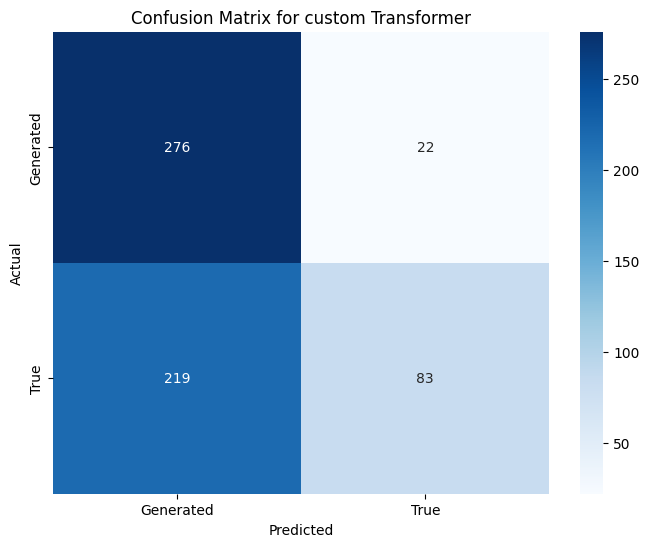

In [44]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    pd.DataFrame(cm, dtype=int),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Generated", "True"],  # data.target_names,
    yticklabels=["Generated", "True"],  # ata.target_names,
)
#ax.text(0.5, 1.5, cm[1, 0])
#ax.text(1.5, 1.5, cm[1, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for custom Transformer")
plt.show()

# Visualization

### Generation from scratch

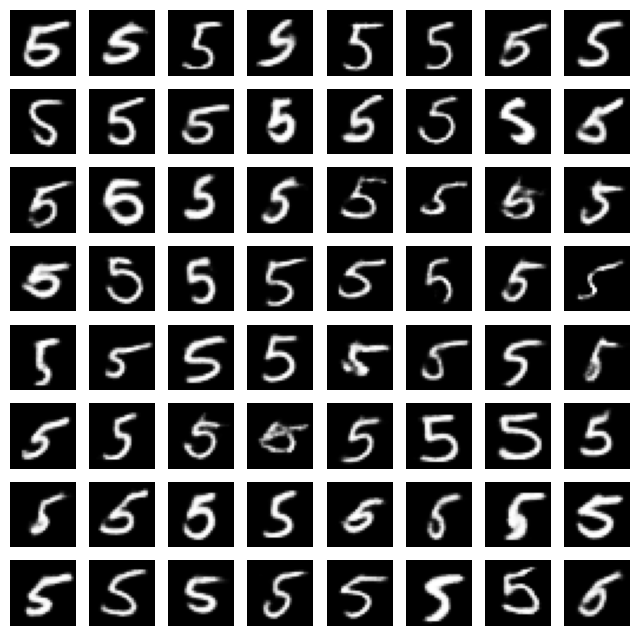

In [47]:
# Generate and visualize images from the latent space
model = vae_model
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample = model.decode(z).cpu()
    sample = sample.view(64, 1, 28, 28)

    # Plot the generated images
    plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(sample[i][0], cmap="gray")
        plt.axis("off")
    plt.show()